# imports de bibliotecas e de database

In [1]:
import re # biblioteca para expressoes regulares
import os # biblioteca sobre o sistema operacional
import nltk # biblioteca para o preprocessamento
import gensim
from zipfile import ZipFile # biblioteca para arquivos zipados
import sklearn as skl
import numpy as np # biblioteca usada para trabalhar com vetores e matrizes
import unicodedata # sera usada para remover acentos dos documentos em lingua portuguesa
import pandas as pd # biblioteca usada para trabalhar com dataframes e análise de dados
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import precision_score, recall_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ParameterGrid
from gensim.models import Word2Vec, KeyedVectors
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from collections import defaultdict




# definição dos pipeline e execução do Grid Search

In [2]:
url = 'https://github.com/gazzola/corpus_readability_nlp_portuguese/archive/refs/heads/master.zip'
url2 = 'http://143.107.183.175:22980/download.php?file=embeddings/word2vec/cbow_s100.zip'

# especifica o local onde ficarao os arquivos
pathFiles = 'dados/'
fileName = 'corpus_readability_nlp_portuguese.zip'

# cria uma pasta onde ficarao os arquivos
if not os.path.isdir(pathFiles):
    os.mkdir(pathFiles)

# faz o download do arquivo
os.system('wget -O %s%s %s' %(pathFiles, fileName, url))
fileName2 = 'cbow_s100.zip'
os.system('wget -O %s%s %s' %(pathFiles, fileName2, url2))

print('Arquivos extraídos com sucesso!')

Arquivos extraídos com sucesso!


In [3]:
# descompacta a base de dados de notícias
z = ZipFile('dados/corpus_readability_nlp_portuguese.zip', 'r')
z.extractall('dados/')
z.close()

z = ZipFile('dados/cbow_s100.zip', 'r')
z.extractall('dados/')
z.close()

In [4]:
def import_Dataset(path):

    files = os.listdir(path)

    dataset = []

    for i, file in enumerate(files):

        # abre o arquivo
        fileTexto = open(path+'/'+file, "r", encoding='utf8', errors='replace') #utf8 #cp1252

        # le o arquivo e armazena o texto dentro da variavel "texto"
        texto = fileTexto.read()

        dataset.append(texto)

    return dataset

# importa as bases de dados
dataset_Fund1 = import_Dataset('dados/corpus_readability_nlp_portuguese-master/1_Ensino_Fundamental_I')
print('Ensino Fundamental 1 importadas com sucesso')
dataset_Fund2 = import_Dataset('dados/corpus_readability_nlp_portuguese-master/2_Ensino_Fundamental_II')
print('Ensino Fundamental 2 importadas com sucesso')
dataset_Medio = import_Dataset('dados/corpus_readability_nlp_portuguese-master/3_Ensino_Medio')
print('Ensino Medio importadas com sucesso')
dataset_Superior = import_Dataset('dados/corpus_readability_nlp_portuguese-master/4_Ensino_Superior')
print('Ensino Superior importadas com sucesso')

# concatena as bases de dados
dataset = np.asarray( dataset_Fund1+dataset_Fund2+dataset_Medio+dataset_Superior)


# cria um vetor para cada classe
target_Fund1 = np.zeros( len(dataset_Fund1), dtype=int )
target_Fund2 = np.ones( len(dataset_Fund2), dtype=int )
target_Medio = np.full(len(dataset_Medio), 2)
target_Superior = np.full(len(dataset_Superior), 3)

# concateca os vetores de classe
target = np.concatenate((target_Fund1, target_Fund2, target_Medio, target_Superior))

# obtem as classes do problema
classes = np.unique(target)

print('\nQtd. textos dataset: %d' %len(dataset))
print('Qtd. textos target: %d' %len(target))

Ensino Fundamental 1 importadas com sucesso
Ensino Fundamental 2 importadas com sucesso
Ensino Medio importadas com sucesso
Ensino Superior importadas com sucesso

Qtd. textos dataset: 2076
Qtd. textos target: 2076


# Preprocessing

In [5]:
!pip install nltk

# Download the stopwords corpus
nltk.download('stopwords')

# Download the RSLPStemmer
nltk.download('rslp')

from nltk.stem import RSLPStemmer # para fazer a estemização em documentos da lingua portuguesa

def preprocessing_portuguese(text, stemming = False, stopwords = False):
    """
    Funcao usada para tratar textos escritos na lingua portuguesa

    Parametros:
        text: variavel do tipo string que contem o texto que devera ser tratado

        stemming: variavel do tipo boolean que indica se a estemizacao deve ser aplicada ou nao

        stopwords: variavel do tipo boolean que indica se as stopwords devem ser removidas ou nao
    """

    ########################## COMPLETE O CÓDIGO AQUI  ########################

    # Lower case
    text = text.lower()

    # remove os acentos das palavras
    nfkd_form = unicodedata.normalize('NFKD', text)
    text = u"".join([c for c in nfkd_form if not unicodedata.combining(c)])

    # remove tags HTML
    regex = re.compile('<[^<>]+>')
    text = re.sub(regex, " ", text)

    # normaliza as URLs
    regex = re.compile('(http|https)://[^\s]*')
    text = re.sub(regex, "<URL>", text)

    # normaliza emails
    regex = re.compile('[^\s]+@[^\s]+')
    text = re.sub(regex, "<EMAIL>", text)

    # converte todos os caracteres não-alfanuméricos em espaço
    regex = re.compile('[^A-Za-z0-9]+')
    text = re.sub(regex, " ", text)

    # normaliza os numeros
    regex = re.compile('[0-9]+.[0-9]+')
    text = re.sub(regex, "NUMERO", text)

    # normaliza os numeros
    regex = re.compile('[0-9]+,[0-9]+')
    text = re.sub(regex, "NUMERO", text)

    # normaliza os numeros
    regex = re.compile('[0-9]+')
    text = re.sub(regex, "NUMERO", text)


    # substitui varios espaçamentos seguidos em um só
    text = ' '.join(text.split())

    # separa o texto em palavras
    words = text.split()

    # trunca o texto para apenas 200 termos
    words = words[0:200]

    # remove stopwords
    if stopwords:
        words = text.split() # separa o texto em palavras
        words = [w for w in words if not w in nltk.corpus.stopwords.words('portuguese')]
        text = " ".join( words )

    # aplica estemização
    if stemming:
        stemmer_method = RSLPStemmer()
        words = [ stemmer_method.stem(w) for w in words ]
        text = " ".join( words )

    # remove palavras compostas por apenas um caracter
    words = text.split() # separa o texto em palavras
    words = [ w for w in words if len(w)>1 ]
    text = " ".join( words )

    return text

class Preprocessing(BaseEstimator, TransformerMixin):
    def __init__(self, stemming=False, stopwords=False):
        self.stemming = stemming
        self.stopwords = stopwords

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return [preprocessing_portuguese(x, self.stemming, self.stopwords) for x in X]
    

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mathe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\mathe\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


# funções para o embedding


In [6]:
import gensim
from gensim.models import Word2Vec

class Embedding(BaseEstimator, TransformerMixin):
    def __init__(self, pretreinado, vector_size, window, min_count ):
        self.pretreinado = pretreinado
        self.vector_size = vector_size
        self.window = window
        self.min_count = min_count
        self.model = None

    def fit(self, X, y=None):
        
        if self.pretreinado:
            self.model = KeyedVectors.load_word2vec_format('dados/cbow_s100.txt')
        else:
            self.model = Word2Vec(sentences = X,
                          vector_size = self.vector_size,
                          window = self.window,
                          min_count = self.min_count)
        return self


    def transform(self, X, y=None):
        if self.pretreinado:
            return self.dataset2featureMatrix2(X, self.model)
        else:
            return self.dataset2featureMatrix(X, self.model)
    
    def getDocvector(self, model, doc):

        wordList = []
        for word in doc:

            try:
                vec = model.wv[word]
                wordList.append(vec)
            except:
                pass

        if len(wordList)>0:
            vetorMedio = np.mean( wordList, axis=0 )
        else:
            vetorMedio = np.zeros( model.vector_size )

        return vetorMedio

    def dataset2featureMatrix(self, dataset, embeddingModel):

    ########################## COMPLETE O CÓDIGO AQUI  ########################

        X_embedding = []
        for doc in dataset:
            vec = self.getDocvector(embeddingModel, doc)
            X_embedding.append(vec)

        X_embedding = np.array(X_embedding)

        ##########################################################################

        return X_embedding
    

    def getDocvector2(self, model, doc):
   

    ########################## COMPLETE O CÓDIGO AQUI  ########################
        wordList2 = []
        for word in doc:
            try:
                vec = model[word]
                wordList2.append(vec)
            except:
                pass
        if len(wordList2)>0:
            vetorMedio = np.mean( wordList2, axis=0 )
        else:        
            vetorMedio = np.zeros( model.vector_size )

        ##########################################################################

        return vetorMedio

    def dataset2featureMatrix2(self, dataset, embeddingModel):

        ########################## COMPLETE O CÓDIGO AQUI  ########################

        word2v = []
        for doc in dataset:
            vec = self.getDocvector2(embeddingModel, doc)
            word2v.append(vec)

        word2v = np.array(word2v)

        ##########################################################################

        return word2v

# nuvem de palavra do dataset

é  possivel observar que precisa do preprocessamento

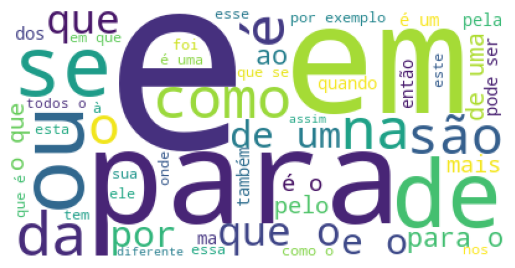

In [7]:
import matplotlib.pyplot as plt
!pip install wordcloud

from wordcloud import WordCloud

wc = WordCloud(min_font_size = 10, max_font_size = 200, 
               background_color = "white", relative_scaling=0.5)

# Adicione o texto à nuvem de palavras
wc.generate(" ".join(dataset))

# Plote a nuvem de palavras
plt.imshow(wc)
plt.axis("off")
plt.show()

# Divisão do dataset 


In [7]:

dataset2 = []
for i, msg in enumerate(dataset):
    dataset2.append(msg.split())

# gera uma divisão dos dados em treino e teste
cv = skl.model_selection.StratifiedShuffleSplit(n_splits=1, train_size=0.8,
                                                random_state=10)

# retorna os índices de treino e teste
train_index, test_index = list( cv.split(dataset, target) )[0]

# retorna as partições de treino e teste de acordo com os índices
dataset2_train, dataset2_test = dataset[train_index], dataset[test_index]
y_train, y_test = target[train_index], target[test_index]

##########################################################################


# definição dos pipeline e execução do Grid Search

In [8]:
RF = RandomForestClassifier()

pipelines = [
    ('Floresta Aleatoria TF', Pipeline([
        ('preprocessing', Preprocessing()),
    ('TF', CountVectorizer()),
    ('clf', RF),
    ])),
    ('Floresta Aleatoria TF-IDF', Pipeline([
        ('preprocessing', Preprocessing()),
        ('vect', TfidfVectorizer()),
        ('clf', RF),
    ])),
    ('Floresta Aleatoria Binario', Pipeline([
        ('preprocessing', Preprocessing()),
        ('vect', CountVectorizer(binary=True)),
        ('clf', RF),
    ])),
    ('Floresta Aleatoria Word2Vec', Pipeline([
        ('preprocessing', Preprocessing()),
        ('embedding', Embedding(pretreinado=False, vector_size=200, window=3,min_count=1)),
        ('scaler', MinMaxScaler()),
        ('clf', RF),
    ])),
    ('Floresta Aleatoria Word2Vec (pre-treinado)', Pipeline([
        ('preprocessing', Preprocessing()),
        ('w2v', Embedding(pretreinado=True, vector_size=200, window=3,min_count=1)),
        ('scaler', MinMaxScaler()),
        ('clf', RF),
    ])),
]

preprocessed_data = defaultdict(dict)
# Definindo a grade de parâmetros
parameters = {
    'preprocessing__stemming': [ True, False],
    'preprocessing__stopwords': [ True, False],
    'clf__n_estimators': [100, 150, 200],
    'clf__max_depth': [None, 5, 10, 20],
}

param_grid = ParameterGrid(parameters)

for name, pipeline in pipelines:
    best_accuracy = 0
    best_macro = 0
    best_params = None
    best_pipeline = None
    print("\nMétodo: ", name)
    for params in param_grid:
        # Verifica se os dados pré-processados já existem no dicionário
        key = (params['preprocessing__stemming'], params['preprocessing__stopwords'])
        if key in preprocessed_data:
            preprocessed_X_train = preprocessed_data[key]['train']
            preprocessed_X_test = preprocessed_data[key]['test']
        else:
            # Realiza o pré-processamento e armazena os resultados no dicionário
            preprocessor = Preprocessing(stemming=params['preprocessing__stemming'], stopwords=params['preprocessing__stopwords'])
            preprocessed_X_train = preprocessor.transform(dataset2_train)
            preprocessed_X_test = preprocessor.transform(dataset2_test)
            preprocessed_data[key]['train'] = preprocessed_X_train
            preprocessed_data[key]['test'] = preprocessed_X_test

        # Ajusta o pipeline aos dados pré-processados
        pipeline.fit(preprocessed_X_train, y_train)
        Y_pred = pipeline.predict(preprocessed_X_test)
        accuracy = accuracy_score(y_test, Y_pred)
        macro_f1 = f1_score(y_test, Y_pred, average='macro')
        precision = precision_score(y_test, Y_pred, average='macro')
        recall = recall_score(y_test, Y_pred, average='macro')
                
        # Se a acurácia for melhor que a melhor acurácia até agora, atualiza a melhor acurácia e os melhores parâmetros
        if macro_f1 > best_macro:
            best_accuracy = accuracy
            best_macro = macro_f1
            best_precision = precision
            best_recall = recall
            best_params = params
            best_pipeline = pipeline

    print("Melhor Acurácia: ", best_accuracy)
    print("Melhor Macro F1: ", best_macro)
    print("Melhor precisão: ", best_precision)
    print("Melhor revocação: ", best_recall)
    print("Melhores Parâmetros: ", best_params)




Método:  Floresta Aleatoria TF
Melhor Acurácia:  0.8485576923076923
Melhor Macro F1:  0.8228600312548311
Melhor precisão:  0.8676235523009717
Melhor revocação:  0.8085758131551475
Melhores Parâmetros:  {'clf__max_depth': None, 'clf__n_estimators': 200, 'preprocessing__stemming': True, 'preprocessing__stopwords': True}

Método:  Floresta Aleatoria TF-IDF
Melhor Acurácia:  0.8701923076923077
Melhor Macro F1:  0.8485151397515528
Melhor precisão:  0.879945913962632
Melhor revocação:  0.8414228154936751
Melhores Parâmetros:  {'clf__max_depth': None, 'clf__n_estimators': 100, 'preprocessing__stemming': True, 'preprocessing__stopwords': True}

Método:  Floresta Aleatoria Binario
Melhor Acurácia:  0.8485576923076923
Melhor Macro F1:  0.817799837416174
Melhor precisão:  0.8643362217459742
Melhor revocação:  0.8034174507678694
Melhores Parâmetros:  {'clf__max_depth': None, 'clf__n_estimators': 150, 'preprocessing__stemming': True, 'preprocessing__stopwords': True}

Método:  Floresta Aleatoria W